In [1]:
#Import libraries as needed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [11]:
#Import single csv file to dataframe
df = pd.read_csv ('madrid_2017.csv', delimiter =',')

In [12]:
#STEP 1: IMPUTE DATA AND MAKE SURE U HAVE CHOSEN
#the most suitable imputaion method

df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index of the DataFrame
df = df.set_index('date')

# Interpolate missing values using time-based interpolation
df= df.interpolate(method='time',limit_direction='both')

# Reset the index to use an integer index instead of 'date'
df = df.reset_index(drop=False)

C:\Users\eleni\AppData\Local\Temp\ipykernel_10904\1193109510.py:40: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[row, col].set_xlim([data.min(), data.max()])  # set x-axis range
C:\Users\eleni\AppData\Local\Temp\ipykernel_10904\1193109510.py:40: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[row, col].set_xlim([data.min(), data.max()])  # set x-axis range


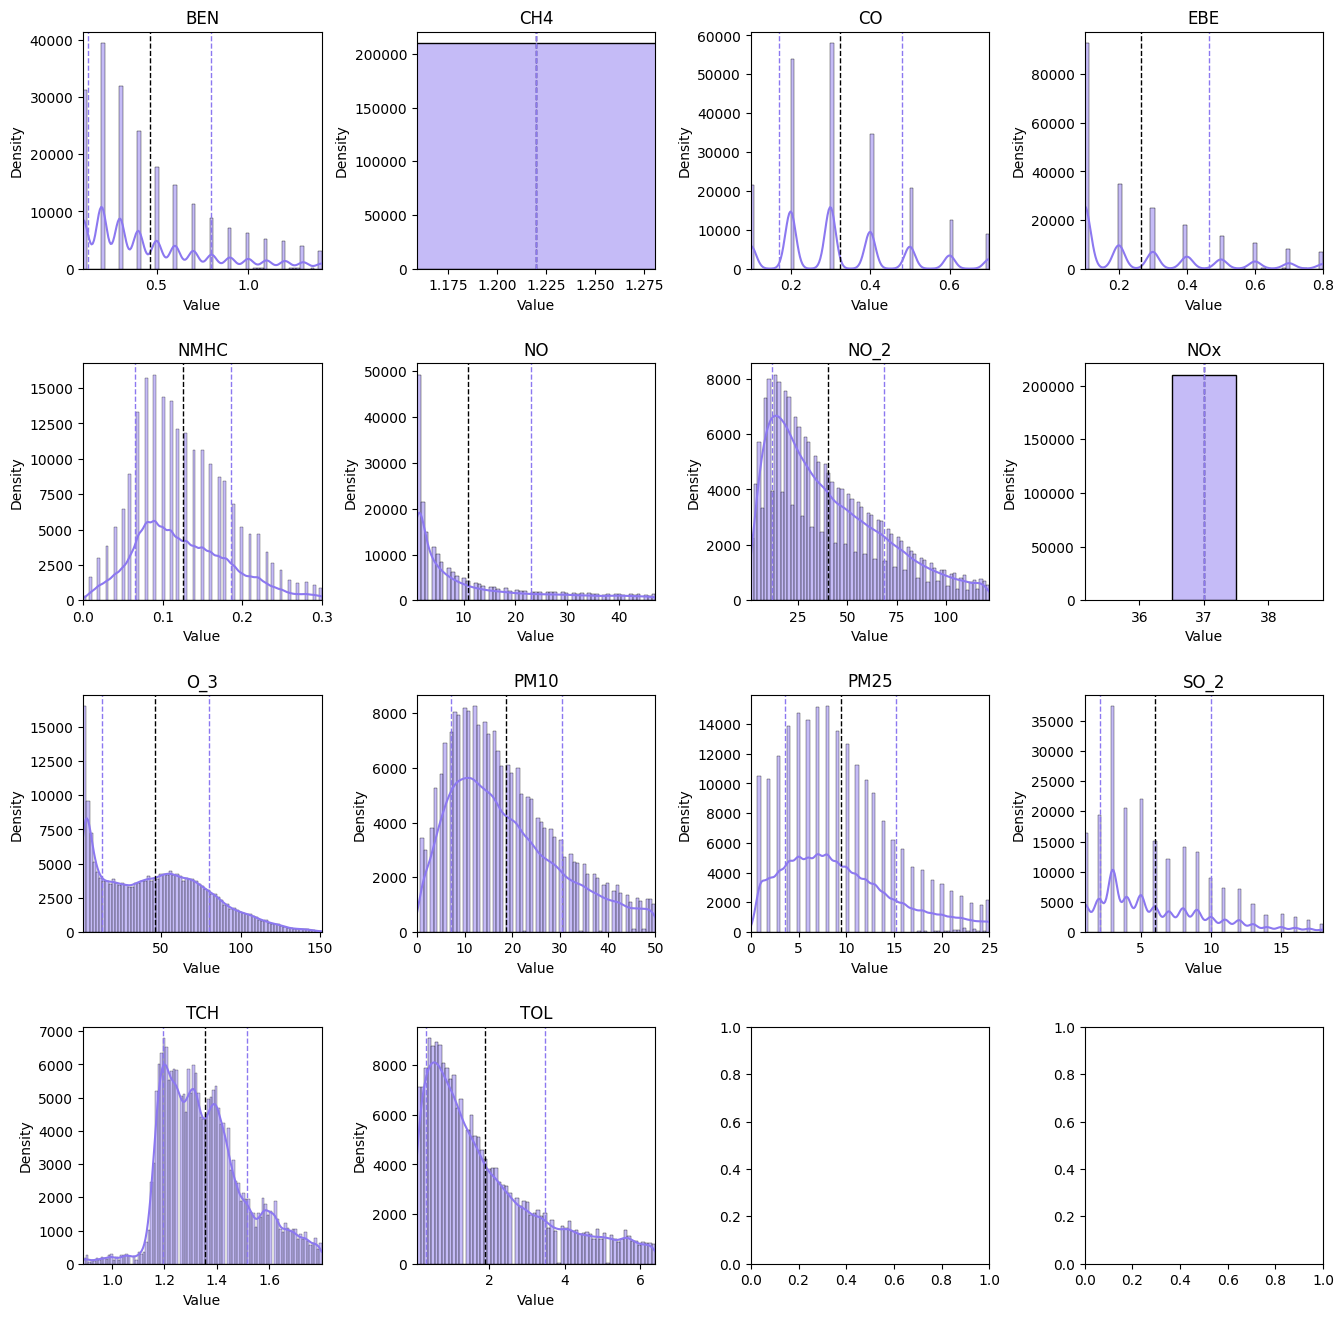

In [17]:
# Get the columns to plot
pollutants = df.columns[1:-1]

# Create a figure with 4x4 subplots
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))

# Plot a histogram for each column
for i, pollutant in enumerate(pollutants):
    # Get the data for the column
    data = df[pollutant].dropna()
    
    # Determine the subplot location based on the column index
    row = i // 4
    col = i % 4
    # get the range of values in the column, ignoring NaN and Inf
    x_min = np.nanmin(df[pollutant][np.isfinite(df[pollutant])])
    x_max = np.nanmax(df[pollutant][np.isfinite(df[pollutant])])
    
    # calculate number of bins using IQR rule
    n = len(df[pollutant])
    std = np.std(df[pollutant])
    k = 3.5 * std / (n**(1/3))
    num_bins = int((x_max - x_min) / k) if k != 0 else 1 # Added this line to handle the case when k=0
    # Plot the histogram with kde
    sns.histplot(data, kde=True, bins=num_bins, color='#8C78F0', ax=axs[row, col])
    
    # Add a vertical line for the mean
    mean = data.mean()
    axs[row, col].axvline(mean, color='k', linestyle='dashed', linewidth=1)
    
    # Add a vertical line for the standard deviation
    std = data.std()
    axs[row, col].axvline(mean+std, color='#8C78F0', linestyle='dashed', linewidth=1)
    axs[row, col].axvline(mean-std, color='#8C78F0', linestyle='dashed', linewidth=1)
    
    # Set the title and axis labels
    axs[row, col].set_title(pollutant)
    axs[row, col].set_xlabel('Value')
    axs[row, col].set_ylabel('Density')
    axs[row, col].set_xlim([data.min(), data.max()])  # set x-axis range

# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Show the plot
plt.show()

In [ ]:
#range calc

# Calculate the range of each column in df
ranges = np.ptp(df, axis=0)

# Print the ranges
print(ranges)

In [ ]:
# mean, median, and standard deviation check
for pollutant in df.columns[1:-1]:
    mean = df[pollutant].mean()
    median = df[pollutant].median()
    std = df[pollutant].std()
    print(f"{pollutant}: mean={mean:.2f}, median={median:.2f}, std={std:.2f}")


In [ ]:
#STEP 3: DEAL WITH OUTLIERS/ NORMALIZE
df_top = df[['CO', 'EBE', 'NO_2', 'O_3', 'PM10', 'PM25','SO_2']]
df_bottom = df[['BEN', 'CH4', 'NMHC', 'NO', 'NOx', 'TCH', 'TOL']]

fig, axs = plt.subplots(2, figsize=(10, 8))

# First plot with first 7 rows
sns.boxplot(data=df_top, palette='PuRd', ax=axs[0])
axs[0].set_xticklabels(df_top.columns, rotation=45)

# Second plot with last 7 rows
sns.boxplot(data=df_bottom, palette='PuRd', ax=axs[1])
axs[1].set_xticklabels(df_bottom.columns, rotation=45)

plt.show()

In [14]:
#IQR OUTLIER REMOVAL AND NORMALIZATION


# Get the columns to normalize
pollutants = df.columns[1:-1]

# Find outliers using the IQR method with k=1.5
Q1 = df[pollutants].quantile(0.25)
Q3 = df[pollutants].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#show number of outliers
outliers = (df[pollutants] < lower_bound) | (df[pollutants] > upper_bound)
print(outliers.sum())

#Remove outliers
df[pollutants] = df[pollutants].mask(outliers)

BEN     16966
CH4     51798
CO      13762
EBE     19953
NMHC     5935
NO      27420
NO_2     5160
NOx     52550
O_3       327
PM10     8603
PM25     8080
SO_2     5006
TCH     11358
TOL     17246
dtype: int64


In [15]:
# Fill NaN values using time-based interpolation
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.interpolate(method='time', limit_direction='both')
df = df.reset_index(drop=False)

In [16]:
nan_counts = df.isnull().sum()
print(nan_counts)

date       0
BEN        0
CH4        0
CO         0
EBE        0
NMHC       0
NO         0
NO_2       0
NOx        0
O_3        0
PM10       0
PM25       0
SO_2       0
TCH        0
TOL        0
station    0
dtype: int64


In [50]:
# SCALE IF NECESARY using the interquartile range (IQR) method
#for pollutant in pollutants:
#    col = df[pollutant]
#    scaler = RobustScaler(with_centering=False, quantile_range=(25.0, 75.0), copy=True, with_scaling=True)
#    df[pollutant] = scaler.fit_transform(col.values.reshape(-1,1))

In [18]:
df.head(100)

,date,BEN,CH4,CO,EBE,NMHC,NO,NO_2,NOx,O_3,PM10,PM25,SO_2,TCH,TOL,station
0,2017-06-01 01:00:00,0.7,1.22,0.3,0.4,0.17,4.0,38.0,37.0,71.0,22.0,9.0,5.0,1.40,1.5,28079004
1,2017-06-01 01:00:00,0.6,1.22,0.3,0.4,0.08,3.0,39.0,37.0,71.0,22.0,9.0,7.0,1.40,2.9,28079008
2,2017-06-01 01:00:00,0.2,1.22,0.3,0.1,0.17,1.0,14.0,37.0,71.0,22.0,9.0,5.0,1.40,0.9,28079011
3,2017-06-01 01:00:00,0.7,1.22,0.2,0.4,0.17,1.0,9.0,37.0,91.0,22.0,9.0,5.0,1.40,1.5,28079016
4,2017-06-01 01:00:00,0.7,1.22,0.3,0.4,0.17,1.0,19.0,37.0,69.0,22.0,9.0,2.0,1.40,1.5,28079017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2017-06-01 04:00:00,0.3,1.22,0.2,0.1,0.08,1.0,11.0,37.0,75.0,8.0,10.0,4.0,1.17,0.1,28079060
96,2017-06-01 05:00:00,0.3,1.22,0.3,0.3,0.09,2.0,17.0,37.0,62.0,12.0,9.0,5.0,1.20,0.8,28079004
97,2017-06-01 05:00:00,0.2,1.22,0.2,0.2,0.11,1.0,20.0,37.0,78.0,15.0,10.0,7.0,1.45,1.3,28079008
98,2017-06-01 05:00:00,0.1,1.22,0.2,0.1,0.09,1.0,13.0,37.0,62.0,12.0,9.0,1.0,1.20,0.5,28079011


In [7]:
num_missing = df.isna().sum()
print(num_missing)

date       0
BEN        0
CH4        0
CO         0
EBE        0
NMHC       0
NO         0
NO_2       0
NOx        0
O_3        0
PM10       0
PM25       0
SO_2       0
TCH        0
TOL        0
station    0
dtype: int64


In [19]:

# Save the DataFrame to a CSV file in the current working directory
df.to_csv('C:\\Users\\eleni\\Documents\\Diplw\\Jupyter-Notebooks\\diplw\\clean_iqr.csv', index=False)